# Задание.

1. Реализуйте функцию, которая проверяет гипотезу о равенстве средних для ratio-метрик с помощью дельта-метода.
2. Проверьте на данных с семинара, что распределение p-value на АА тестрах равномерно, и мощность совпадает с мощностями линеаризации и бутстрепа.

In [33]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

In [34]:
def check_delta_method(a, b):
    """Проверка гипотезы о равенстве средних метрики отношения с помощью дельта-метода.

    a: List[List], список списков длин сессий пользователей контрольной группы
    b: List[List], список списков длин сессий пользователей пилотной группы

    return: (pvalue, pe) - pvalue и точечная оценка разности средних (b-a).
    """
    len_a = len(a)
    len_b = len(b)
    xy_a = np.array([[sum(row), len(row)] for row in a])
    xy_b = np.array([[sum(row), len(row)] for row in b])

    x_mean_a, y_mean_a = xy_a[:, 0].mean(), xy_a[:, 1].mean()
    x_mean_b, y_mean_b = xy_b[:, 0].mean(), xy_b[:, 1].mean()
    x_var_a, y_var_a, xy_cov_a = xy_a[:, 0].var(), xy_a[:, 1].var(), np.cov(xy_a[:, 0], xy_a[:, 1])[0, 1]
    x_var_b, y_var_b, xy_cov_b = xy_b[:, 0].var(), xy_b[:, 1].var(), np.cov(xy_b[:, 0], xy_b[:, 1])[0, 1]
    var_a = (x_var_a - 2 * x_mean_a / y_mean_a * xy_cov_a + (x_mean_a / y_mean_a)**2 * y_var_a) / (len_a * y_mean_a**2)
    var_b = (x_var_b - 2 * x_mean_b / y_mean_b * xy_cov_b + (x_mean_b / y_mean_b)**2 * y_var_b) / (len_b * y_mean_b**2)

    pe = xy_b[:, 0].sum() / xy_b[:, 1].sum() - xy_a[:, 0].sum() / xy_a[:, 1].sum()
    t = pe / (var_a + var_b)**0.5
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))

    return pvalue, pe 

In [35]:
def plot_pvalue_distribution_power(dict_pvalues, alpha=0.05):
    """Рисует графики распределения pvalue."""
    X = np.linspace(0, 1, 1000)
    for key, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues <= x) for x in X]
        prob_p = np.mean(np.array(pvalues) < alpha)
        plt.plot(X, Y, label=f'{key}, prob_p={prob_p:0.2f}')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

In [36]:
df = pd.read_csv('06-game_sessions.csv', parse_dates=['date'])
df_prepilot = df[df['date'] < datetime(2024, 5, 11)].copy()

  0%|          | 0/10000 [00:00<?, ?it/s]

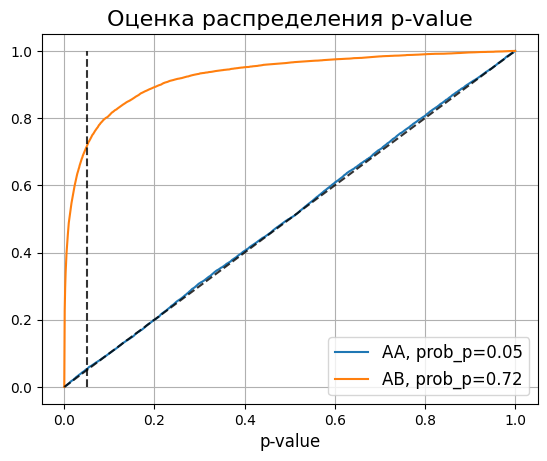

In [37]:
sample_size = 500
effect = 30

lengths = df_prepilot.groupby('user_id')['value'].apply(list).values

len_ = len(lengths)
dict_pvalues = defaultdict(list)
for _ in tqdm(range(10000)):
    a, b = np.random.choice(lengths, (2, sample_size), False)
    pvalue_aa = check_delta_method(a, b)[0]
    dict_pvalues['AA'].append(pvalue_aa)
    b_effect = [list(np.array(row) + effect) for row in b]
    pvalue_ab = check_delta_method(a, b_effect)[0]
    dict_pvalues['AB'].append(pvalue_ab)
plot_pvalue_distribution_power(dict_pvalues)

In [38]:
df_pilot = df[df['date'] >= datetime(2024, 5, 11)].copy()
a, b = [
    df_pilot[df_pilot['group'] == group].groupby('user_id')['value'].apply(list).tolist()
    for group in [0, 1]
]
pvalue, pe = check_delta_method(a, b)
pvalue, pe

(0.22951068774483296, 13.513984962406028)

Как видим на графике, pvalue распределено равномерно, а мощность равна 0.71, что равна мощностям линеаризации и бутстрепа с семинара. Результаты на данных с экспериментом также схожи.